# Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Definition

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [3]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

In [4]:
class SchrodingerPINN(nn.Module):
    def __init__(self, layers, lower, upper, activation=nn.Tanh()):
        super(SchrodingerPINN, self).__init__()
        self.layers = []
        self.lower = lower
        self.upper = upper
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(activation)
        self.model = nn.Sequential(*self.layers)
        self.model.apply(weights_init)  # xavier initialization
        assert self.layers[-1].out_features == 2 # real part and imaginary part
        assert self.lower.shape == self.upper.shape == torch.Size([self.layers[0].in_features])

    def forward(self, _time, *coordinates):
        assert self.layers[0].in_features == len([_time, *coordinates])
        # time and coordinates (x, y, z)
        psi = self.model((torch.cat([_time, *coordinates], dim=1) -
                          self.lower) / (self.upper - self.lower)) # Min-max scaling
        real = psi[:, 0:1]
        imaginary = psi[:, 1:2]
        return real, imaginary

In [5]:
def pde_loss(model, t, x):
    t = t.clone().detach().requires_grad_(True).to(device)
    x = x.clone().detach().requires_grad_(True).to(device)

    u, v = model(t, x)
    u.requires_grad_(True)
    v.requires_grad_(True)

    '''
    # Cannot write like this!

    u_t, u_x = grad(outputs=u, inputs=(t, x),
                    grad_outputs=torch.ones_like(u),
                    create_graph=True, retain_graph=True)

    u_xx = grad(outputs=u_x, inputs=x,
                grad_outputs=torch.ones_like(u_x),
                create_graph=True, retain_graph=True)[0]

    v_t, v_x = grad(outputs=u, inputs=(t, x),
                    grad_outputs=torch.ones_like(u),
                    create_graph=True, retain_graph=True)

    v_xx = grad(outputs=v_x, inputs=x,
                grad_outputs=torch.ones_like(v_x),
                create_graph=True, retain_graph=True)[0]
    '''

    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    v_t = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x.sum(), x, create_graph=True)[0]

    f_u = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u  # u
    # https://mp.weixin.qq.com/s/VzYxK4W9fVktjhpNdv7DGw
    # f_u = -v_t + 0.5 * u_xx + (u ** 2 + v ** 2) * u  # u
    # https://github.com/CVC-Lab/RobustPINNs/blob/main/NonLinear-Schrodinger1D/code/PINN.py
    f_v = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v  # v
    f_target = torch.zeros_like(f_u).to(device)

    mse_pde = loss_fn(f_u, f_target) + loss_fn(f_v, f_target)
    return mse_pde

In [6]:
def bc_loss(model, t, x_lower, x_upper):
    t = t.clone().detach().requires_grad_(True).to(device)
    x_lower = x_lower.clone().detach().requires_grad_(True).to(device)
    x_upper = x_upper.clone().detach().requires_grad_(True).to(device)

    u_lb, v_lb = model(t, x_lower)
    u_lb.requires_grad_(True)
    v_lb.requires_grad_(True)

    u_ub, v_ub = model(t, x_upper)
    u_ub.requires_grad_(True)
    v_ub.requires_grad_(True)

    mse_bc1_u = loss_fn(u_lb, u_ub)
    mse_bc1_v = loss_fn(v_lb, v_ub)

    u_x_lb = grad(u_lb.sum(), x_lower, create_graph=True)[0]
    u_x_ub = grad(u_ub.sum(), x_upper, create_graph=True)[0]

    v_x_lb = grad(v_lb.sum(), x_lower, create_graph=True)[0]
    v_x_ub = grad(v_ub.sum(), x_upper, create_graph=True)[0]

    mse_bc2_u = loss_fn(u_x_lb, u_x_ub)
    mse_bc2_v = loss_fn(v_x_lb, v_x_ub)

    mse_bc = mse_bc1_u + mse_bc1_v + mse_bc2_u + mse_bc2_v

    return mse_bc

In [7]:
def ic_loss(model, t, x, u_initial, v_initial):
    t = t.clone().detach().requires_grad_(True).to(device)
    x = x.clone().detach().requires_grad_(True).to(device)
    u_initial = u_initial.clone().detach().requires_grad_(True).to(device)
    v_initial = v_initial.clone().detach().requires_grad_(True).to(device)

    u, v = model(t, x)
    u.requires_grad_(True)
    v.requires_grad_(True)

    mse_ic = loss_fn(u, u_initial) + loss_fn(v, v_initial)

    return mse_ic

# Data Preparation

In [8]:
def latin_hypercube_sampling(n: int, samples: int) -> torch.Tensor:
    """
    Latin Hypercube Sampling
    """
    lhs = torch.rand(samples, n).to(device) # uniform distribution on the interval [0,1)
    for d in range(n):
        # For each sample, randomly select a point in the corresponding interval
        lhs[:, d] = (torch.randperm(samples).to(device) + 1.0 - lhs[:, d]) / samples
    return lhs

#print(latin_hypercube_sampling(2, 10))

In [9]:
N_ic = 512 # Number of initial value points
N_bc = 128 # Number of boundary points
N_f = 65536 # Number of function points

x_min = -5.0
x_max = 5.0
t_min = 0.0
t_max = torch.pi / 2.0

In [10]:
lb = torch.tensor([t_min, x_min]).to(device) # lower boundary
ub = torch.tensor([t_max, x_max]).to(device) # upper boundary

# IC
t_ic = torch.zeros(N_ic, 1)
t_ic.to(device)
# x_ic = x_min + (x_max - x_min) * torch.rand(N_ic, 1)
x_ic = x_min + (x_max - x_min) * latin_hypercube_sampling(1, N_ic)
x_ic.to(device)
u_ic = 2 * (2 / (torch.exp(x_ic) + torch.exp(-x_ic)))  # 2 * sech(x)
u_ic.to(device)
v_ic = torch.zeros(N_ic, 1)
v_ic.to(device)

# BC
# t_b = t_min + (t_max - t_min) * torch.rand(N_bc, 1)
t_b = t_min + (t_max - t_min) * latin_hypercube_sampling(1, N_bc)
t_b.to(device)
x_lb = torch.ones(N_bc, 1) * x_min
x_lb.to(device)
x_ub = torch.ones(N_bc, 1) * x_max
x_ub.to(device)

# PDE
tx_f = lb + (ub - lb) * latin_hypercube_sampling(2, N_f)
tx_f.to(device)

tensor([[ 0.4685, -3.4725],
        [ 1.2457,  0.2159],
        [ 0.8986, -1.0709],
        ...,
        [ 1.1324, -1.4003],
        [ 1.3774, -3.7061],
        [ 0.3214,  0.0366]])

# Training

In [11]:
model_path = "/content/drive/My Drive/Colab Notebooks/Deep_Learning_Project/PINN_model.pt"
# model_path = "PINN_model.pt"
use_saved = False

layers = [2, 128, 128, 128, 128, 128, 2]
if use_saved:
    model = torch.load(model_path, map_location=torch.device(device)).to(device)
else:
    model = SchrodingerPINN(layers, lb, ub).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

lbfgs_optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50000,
    max_eval=50000,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * torch.finfo(torch.float64).eps,
    history_size=50,
    line_search_fn="strong_wolfe",
)
# https://mp.weixin.qq.com/s/VzYxK4W9fVktjhpNdv7DGw
# https://arxiv.org/pdf/2205.07195.pdf

In PyTorch, **model.train()** is a method used to put the model in "training mode." This is important because certain modules behave differently during training than they do during evaluation. For instance, layers like **Dropout** and **BatchNorm** need to behave differently when training a model versus when making predictions (inference).

In [12]:
epochs = 20000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    _pde = pde_loss(model, tx_f[:, 0:1], tx_f[:, 1:2])
    _bc = bc_loss(model, t_b, x_lb, x_ub)
    _ic = ic_loss(model, t_ic, x_ic, u_ic, v_ic)
    loss = (_pde + _bc + _ic)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        torch.save(model, model_path)
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}, PDE: {_pde.item():.3e}, BC: {_bc.item():.3e}, IC: {_ic.item():.3e}")

KeyboardInterrupt: ignored

In [13]:
total_epochs = epochs
def closure():
    global total_epochs
    model.train()
    lbfgs_optimizer.zero_grad()
    mse_pde = pde_loss(model, tx_f[:, 0:1], tx_f[:, 1:2])
    mse_bc = bc_loss(model, t_b, x_lb, x_ub)
    mse_ic = ic_loss(model, t_ic, x_ic, u_ic, v_ic)
    loss = mse_ic + mse_bc + mse_pde
    loss.backward()
    total_epochs += 1
    if (total_epochs + 1) % 100 == 0:
        torch.save(model, model_path)
        print(f"Epoch {total_epochs + 1}, Loss: {loss.item()}, PDE: {mse_pde.item():.3e}, BC: {mse_bc.item():.3e}, IC: {mse_ic.item():.3e}")
    return loss

In [14]:
print("Using L-BFGS to optimize...")
lbfgs_optimizer.step(closure)
torch.save(model, model_path)
print("L-BFGS optimizing finished.")
print("Total Epochs:", total_epochs)

Using L-BFGS to optimize...


KeyboardInterrupt: ignored

# Evaluation

In [24]:
# Load the the saved file
loaded_model = torch.load(model_path, map_location=torch.device(device)).to(device)

# Set the model to evaluation mode if you plan to use it for inference
loaded_model.eval()

len_eval = 1000

with torch.no_grad():
    t_eval = t_min + (torch.arange(1, len_eval + 1).to(device) / len_eval - (0.5 / len_eval)) * (t_max - t_min)
    x_eval = x_min + (torch.arange(1, len_eval + 1).to(device) / len_eval - (0.5 / len_eval)) * (x_max - x_min)
    # Cartesian product
    all_points = torch.cartesian_prod(t_eval, x_eval).to(device) # (t, x)
    # torch.cartesian_prod: The behavior is similar to python’s itertools.product
    assert all_points.shape == (len_eval * len_eval, 2)
    real_part, imaginary_part = loaded_model(all_points[:, 0:1], all_points[:, 1:2])
    all_results = torch.sqrt(real_part.squeeze()**2 + imaginary_part.squeeze()**2)
    assert all_results.shape == torch.Size([len_eval * len_eval])

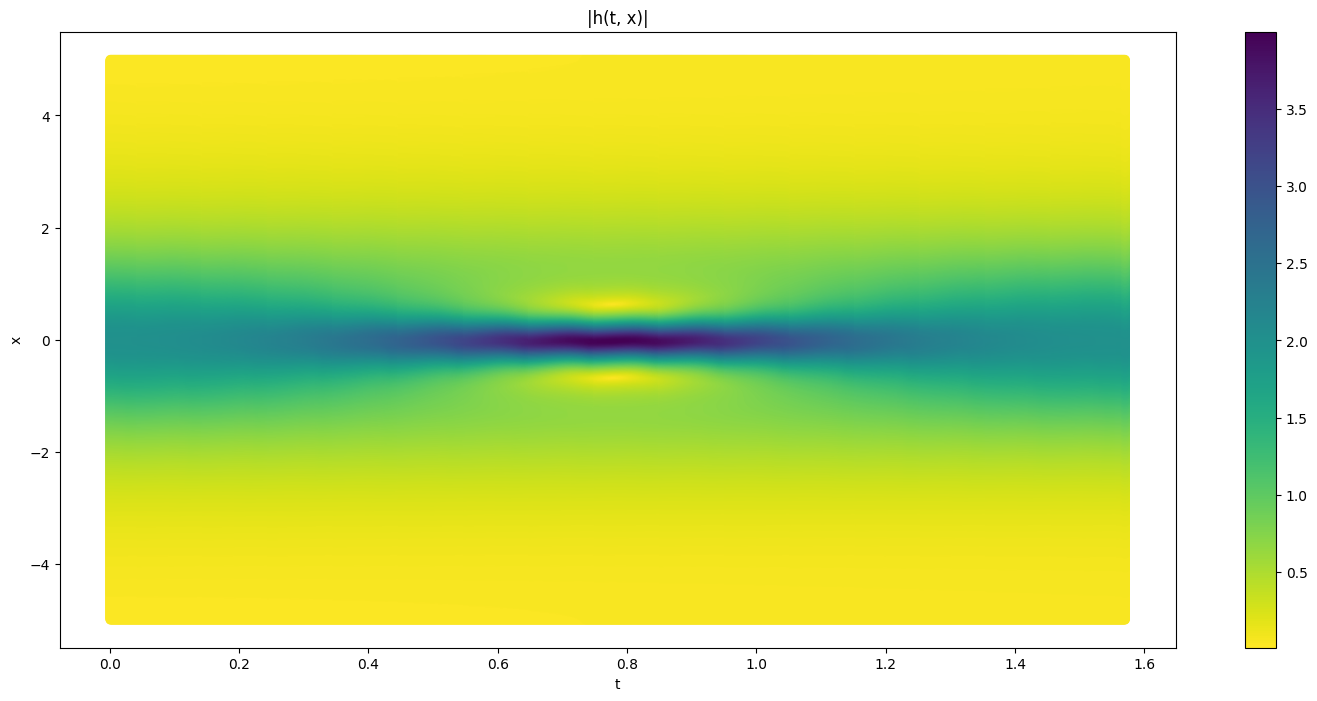

In [25]:
plt.figure(figsize=(18, 8))

# Create scatter plot
plt.scatter(all_points[:, 0:1].squeeze().cpu(), all_points[:, 1:2].squeeze().cpu(), c=all_results.cpu(), cmap='viridis_r')
# 'viridis' is a color map, you can choose others
# cmap='plasma'

# Add a color bar
plt.colorbar()

# Add labels and title if needed
plt.xlabel('t')
plt.ylabel('x')
plt.title('|h(t, x)|')

# Show the plot
plt.show()

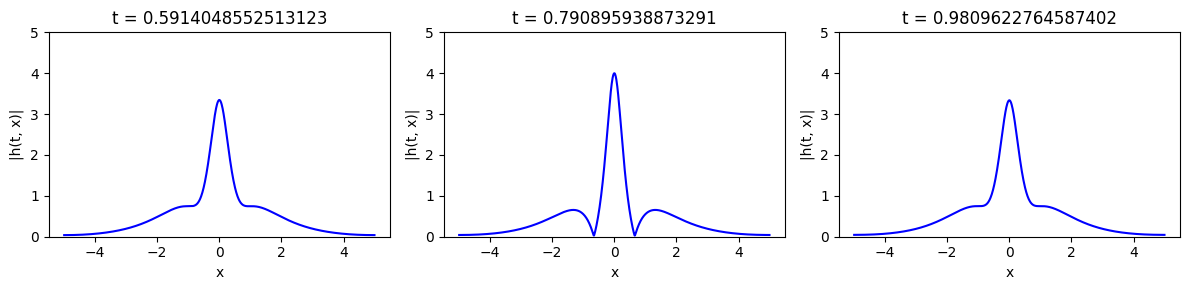

In [26]:
# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# First subplot
t_1 = int(0.376 * len_eval)
ax1.set_ylim(0, 5)
ax1.plot(x_eval.cpu(), all_results[len_eval * t_1:len_eval * (t_1 + 1)].cpu(), 'b-')
ax1.set_title('t = ' + str(float(t_eval[t_1])))
ax1.set_xlabel('x')
ax1.set_ylabel('|h(t, x)|')

# Second subplot
t_2 = int(0.503 * len_eval)
ax2.set_ylim(0, 5)
ax2.plot(x_eval.cpu(), all_results[len_eval * t_2:len_eval * (t_2 + 1)].cpu(), 'b-')
ax2.set_title('t = ' + str(float(t_eval[t_2])))
ax2.set_xlabel('x')
ax2.set_ylabel('|h(t, x)|')

# Third subplot
t_3 = int(0.624 * len_eval)
ax3.set_ylim(0, 5)
ax3.plot(x_eval.cpu(), all_results[len_eval * t_3:len_eval * (t_3 + 1)].cpu(), 'b-')  # Blue line
ax3.set_title('t = ' + str(float(t_eval[t_3])))
ax3.set_xlabel('x')
ax3.set_ylabel('|h(t, x)|')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()